In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import Resize, Pad
from datasets.transform import Transform

from models import Encoder, Decoder, ConditionalDiffusion
from datasets.tabletop_datasets import TabletopDiffusionDataset
from datasets.tabletop_datasets import CondTabletopDiffusionDataset
from datasets.tabletop_datasets import TargetTabletopDiffusionDataset

## Evaluate Encoder

In [2]:
remove_bg = False
data_dir = '/ssd/disk/TableTidyingUp/dataset_template/train'
batch_size = 8
dataset = TabletopDiffusionDataset(data_dir, remove_bg)
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=1)

skip /ssd/disk/TableTidyingUp/dataset_template/train/O9/template_00001/traj_00002 (4 steps)


In [3]:
encoder_path = '0626_1940'
ckpt_dir = '/home/gun/ssd/disk/PreferenceDiffusion/tidying-line-diffusion'
latent_dim = 16

device = torch.device('cuda')
encoder = Encoder(output_dim=latent_dim).to(device)
decoder = Decoder(input_dim=latent_dim).to(device)

state_dict = torch.load(os.path.join(ckpt_dir, 'encoder_%s/checkpoint_best.pt' %encoder_path))
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])

[ models/temporal ] Channel dimensions: [(3, 32), (32, 64), (64, 128), (128, 256)]
[(3, 32), (32, 64), (64, 128), (128, 256)]
[ models/temporal ] Channel dimensions: [(16, 256), (256, 128), (128, 64), (64, 32)]


<All keys matched successfully>

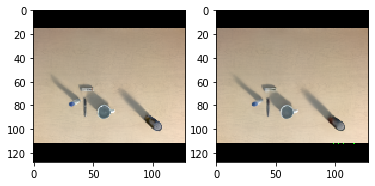

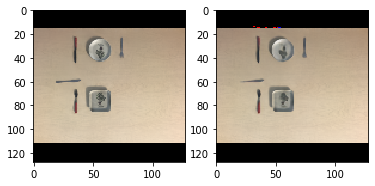

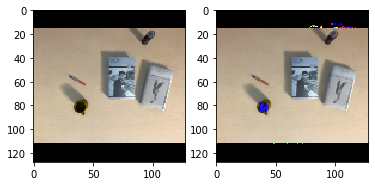

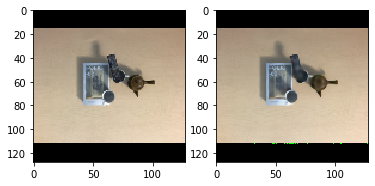

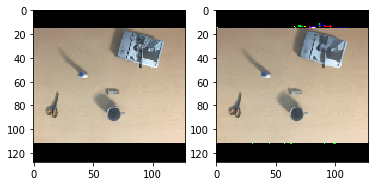

In [4]:
transform = transforms.Compose([Resize([96, 128]), Pad([0, 16, 0, 16])])
#resize = Resize((128, 128))

for batch in data_loader:
    x, mask = batch
    x = transform(x.permute((0, 3, 1, 2)))
    x = x.to(torch.float32).to(device)
    posterior, prior_loss = encoder(x)
    z = posterior.rsample()
    x_recon = decoder(z)
    img = x.permute((0, 2, 3, 1)).detach().cpu()
    img = (img * 255).numpy().astype(np.uint8)
    #img = ((img + 1) * 255 / 2).numpy().astype(np.uint8)
    img_recon = x_recon.permute((0, 2, 3, 1)).detach().cpu()
    img_recon = (img_recon * 255).numpy().astype(np.uint8)
    #img_recon = ((img_recon + 1) * 255 / 2).numpy().astype(np.uint8)
    for i in range(5):
        plt.subplot(1, 2, 1)
        plt.imshow(img[i])
        plt.subplot(1, 2, 2)
        plt.imshow(img_recon[i])
        plt.show()
    break

## Evaluate Diffusion (No Cond)

In [2]:
remove_bg = False
data_dir = '/ssd/disk/TableTidyingUp/dataset_template/train'
batch_size = 4
dataset = TabletopDiffusionDataset(data_dir, remove_bg)
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=1)

skip /ssd/disk/TableTidyingUp/dataset_template/train/O9/template_00001/traj_00002 (4 steps)


In [3]:
ldm_path = '0627_0100'

latent_dim = 16
n_timesteps = 1000
ckpt_dir = '/home/gun/ssd/disk/PreferenceDiffusion/tidying-line-diffusion'

device = torch.device('cuda')
encoder = Encoder(output_dim=latent_dim).to(device)
decoder = Decoder(input_dim=latent_dim).to(device)
diffusion = ConditionalDiffusion(input_dim=latent_dim, cond_dim=latent_dim, n_timesteps=n_timesteps).to(device)

ldm_dir = [d for d in os.listdir(ckpt_dir) if d.startswith('diffusion_') and d.endswith(ldm_path)][0]
state_dict = torch.load(os.path.join(ckpt_dir, ldm_dir, 'checkpoint_best.pt'))
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])
diffusion.load_state_dict(state_dict['diffusion'])

[ models/temporal ] Channel dimensions: [(3, 32), (32, 64), (64, 128), (128, 256)]
[(3, 32), (32, 64), (64, 128), (128, 256)]
[ models/temporal ] Channel dimensions: [(16, 256), (256, 128), (128, 64), (64, 32)]
[ models/temporal ] Channel dimensions: [(16, 128), (128, 256), (256, 512), (512, 1024)]
[(16, 128), (128, 256), (256, 512), (512, 1024)]


<All keys matched successfully>

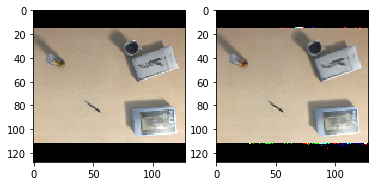

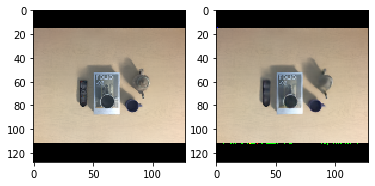

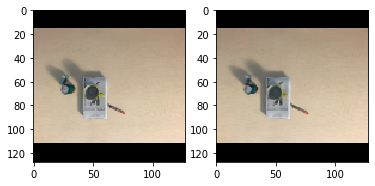

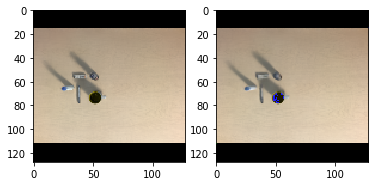

In [4]:
transform = transforms.Compose([Resize([96, 128]), Pad([0, 16, 0, 16])])
#resize = Resize((128, 128))

for batch in data_loader:
    x, masks = batch
    x = transform(x.permute((0, 3, 1, 2)))
    x = x.to(torch.float32).to(device)
    posterior, _ = encoder(x)
    z = posterior.rsample()
    img_recon = decoder(z)
    
    img = x #decoder(feature)
    
    img = img.permute((0, 2, 3, 1)).detach().cpu()
    img = (img * 255).numpy().astype(np.uint8)
    
    img_recon = img_recon.permute((0, 2, 3, 1)).detach().cpu()
    img_recon = (img_recon * 255).numpy().astype(np.uint8)
    
    for i in range(4):
        plt.subplot(1, 2, 1)
        plt.imshow(img[i])
        plt.subplot(1, 2, 2)
        plt.imshow(img_recon[i])
        plt.show()
    break

## Evaluate Diffusion (Conditional)

In [2]:
remove_bg = False
data_dir = '/ssd/disk/TableTidyingUp/dataset_template/train'
batch_size = 4
dataset = CondTabletopDiffusionDataset(data_dir, remove_bg)
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=1)

skip /ssd/disk/TableTidyingUp/dataset_template/train/O9/template_00001/traj_00002 (4 steps)


In [3]:
ldm_path = '0629_1623'
cond_type = 'point'

latent_dim = 16
n_timesteps = 1000
ckpt_dir = '/home/gun/ssd/disk/PreferenceDiffusion/tidying-line-diffusion'

device = torch.device('cuda')
encoder = Encoder(output_dim=latent_dim).to(device)
decoder = Decoder(input_dim=latent_dim).to(device)
diffusion = ConditionalDiffusion(input_dim=latent_dim, cond_dim=latent_dim, n_timesteps=n_timesteps).to(device)

ldm_dir = [d for d in os.listdir(ckpt_dir) if d.startswith('PD_') and d.endswith(ldm_path)][0]
state_dict = torch.load(os.path.join(ckpt_dir, ldm_dir, 'checkpoint-5.pt'))
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])
diffusion.load_state_dict(state_dict['diffusion'])

[ models/temporal ] Channel dimensions: [(3, 32), (32, 64), (64, 128), (128, 256)]
[(3, 32), (32, 64), (64, 128), (128, 256)]
[ models/temporal ] Channel dimensions: [(16, 256), (256, 128), (128, 64), (64, 32)]
[ models/temporal ] Channel dimensions: [(16, 128), (128, 256), (256, 512), (512, 1024)]
[(16, 128), (128, 256), (256, 512), (512, 1024)]


<All keys matched successfully>

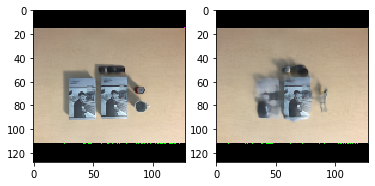

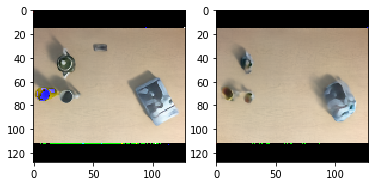

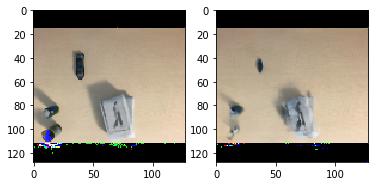

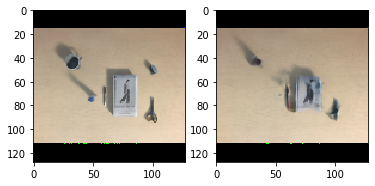

In [4]:
transform = transforms.Compose([Resize([96, 128]), Pad([0, 16, 0, 16])])
transform_seg = transforms.Compose([Resize([96, 128]), Pad([0, 16, 0, 16]), Resize([16, 16])])

for batch in data_loader:
    x, masks, _ = batch
    x = transform(x.permute((0, 3, 1, 2)))
    x = x.to(torch.float32).to(device)
    masks = torch.round(transform_seg(masks)).to(device)
    posterior, _ = encoder(x)
    feature = posterior.mean

    cond = (masks != 0).to(torch.float32).view(-1, 1, 16, 16) * feature
    if cond_type=='point':
        cond = (masks!=0).to(torch.float32).view(-1, 1, 16, 16) * feature
    elif cond_type=='mask':
        cond = torch.zeros_like(feature)
        for m in range(1, int(masks.max())+1):
            mask_m = (masks==m).to(torch.float32).view(-1, 1, 16, 16)
            count_m = mask_m.sum((2, 3))
            feature_m = mask_m * feature
            feature_m_mean = feature_m.sum((2, 3)) / count_m
            feature_m_mean = torch.where(count_m==0, torch.zeros_like(feature_m_mean), feature_m_mean)
            cond += mask_m * feature_m_mean.view(-1, 16, 1, 1)
    feature_recon = diffusion(cond)
    
    img = decoder(feature)
    img_recon = decoder(feature_recon)
    
    img = img.permute((0, 2, 3, 1)).detach().cpu()
    img = (img * 255).numpy().astype(np.uint8)
    
    img_recon = img_recon.permute((0, 2, 3, 1)).detach().cpu()
    img_recon = (img_recon * 255).numpy().astype(np.uint8)
    for i in range(4):
        plt.subplot(1, 2, 1)
        plt.imshow(img[i])
        plt.subplot(1, 2, 2)
        plt.imshow(img_recon[i])
        plt.show()
    break

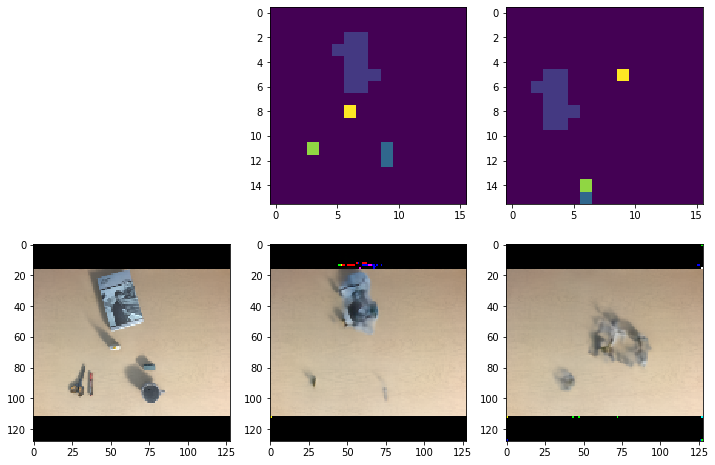

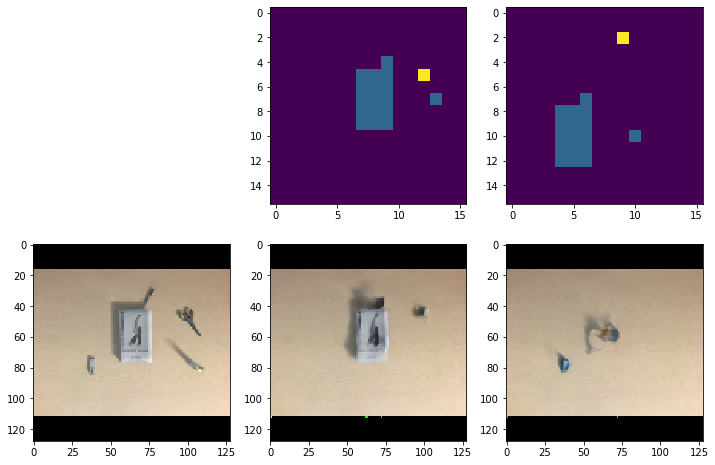

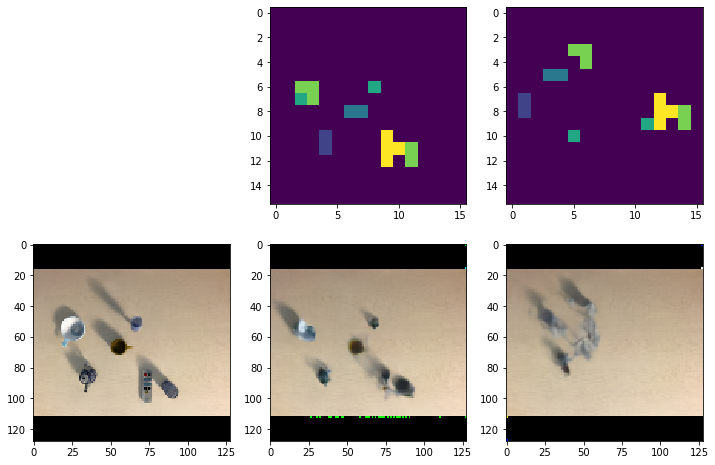

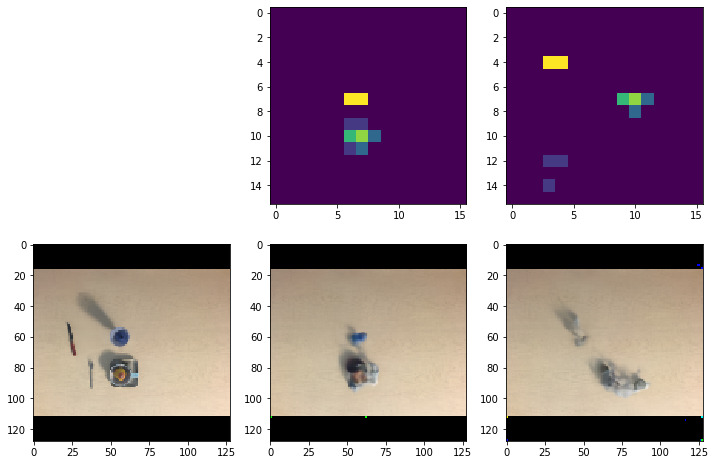

In [5]:
def generate_new_masks(masks):
    new_masks = torch.zeros_like(masks)
    masks_npy = masks.detach().cpu().numpy()
    for m, mask_npy in enumerate(masks_npy):
        new_mask_npy = np.zeros_like(mask_npy)
        for i in range(1, int(mask_npy.max())+1):
            py, px = np.where(mask_npy==i)
            if len(py)==0:
                continue
            while True:
                bias_y, bias_x = np.random.choice([3, -3], 2)
                my, mx = py + bias_y, px + bias_x
                if not (my.max()>=16 or my.min()<0 or mx.max()>=16 or mx.min()<0):
                    break
            new_masks[m, my, mx] = i
    return new_masks

transform = transforms.Compose([Resize([96, 128]), Pad([0, 16, 0, 16])])
transform_seg = transforms.Compose([Resize([96, 128]), Pad([0, 16, 0, 16]), Resize([16, 16])])

for batch in data_loader:
    x, masks, _ = batch
    x = transform(x.permute((0, 3, 1, 2)))
    x = x.to(torch.float32).to(device)
    masks = torch.round(transform_seg(masks))
    new_masks = generate_new_masks(masks)
    masks = masks.to(device)
    new_masks = new_masks.to(device)
    posterior, _ = encoder(x)
    feature = posterior.mean

    if cond_type=='point':
        cond = (masks!=0).to(torch.float32).view(-1, 1, 16, 16) * feature
    elif cond_type=='mask':
        cond = torch.zeros_like(feature)
        for m in range(1, int(masks.max())+1):
            mask_m = (masks==m).to(torch.float32).view(-1, 1, 16, 16)
            count_m = mask_m.sum((2, 3))
            feature_m = mask_m * feature
            feature_m_mean = feature_m.sum((2, 3)) / count_m
            feature_m_mean = torch.where(count_m==0, torch.zeros_like(feature_m_mean), feature_m_mean)
            cond += mask_m * feature_m_mean.view(-1, 16, 1, 1)
    feature_recon = diffusion(cond)
    
    if cond_type=='point':
        cond_prime = (new_masks!=0).to(torch.float32).view(-1, 1, 16, 16) * feature
    elif cond_type=='mask':
        cond_prime = torch.zeros_like(feature)
        for m in range(1, int(masks.max())+1):
            new_mask_m = (new_masks==m).to(torch.float32).view(-1, 1, 16, 16)
            count_m = new_mask_m.sum((2, 3))
            feature_m = new_mask_m * feature
            feature_m_mean = feature_m.sum((2, 3)) / count_m
            feature_m_mean = torch.where(count_m==0, torch.zeros_like(feature_m_mean), feature_m_mean)
            cond_prime += new_mask_m * feature_m_mean.view(-1, 16, 1, 1)
    feature_recon_prime = diffusion(cond_prime)
    
    #img = decoder(feature)
    img_recon = decoder(feature_recon)
    img_recon_prime = decoder(feature_recon_prime)
    
    x_raw = (x.detach().cpu().permute((0, 2, 3, 1)).numpy() * 255).astype(np.uint8)
    img_recon = img_recon.permute((0, 2, 3, 1)).detach().cpu()
    img_recon = (img_recon * 255).numpy().astype(np.uint8)
    img_recon_prime = img_recon_prime.permute((0, 2, 3, 1)).detach().cpu()
    img_recon_prime = (img_recon_prime * 255).numpy().astype(np.uint8)
    
    masks_npy = masks.detach().cpu().numpy()
    new_masks_npy = new_masks.detach().cpu().numpy()
    for i in range(4):
        f = plt.figure(figsize=(12, 8))
        #plt.subplot(2, 3, 1)
        #plt.imshow(x_raw[i])
        plt.subplot(2, 3, 2)
        plt.imshow(masks_npy[i])
        plt.subplot(2, 3, 3)
        plt.imshow(new_masks_npy[i])
        plt.subplot(2, 3, 4)
        plt.imshow(x_raw[i])
        plt.subplot(2, 3, 5)
        plt.imshow(img_recon[i])
        plt.subplot(2, 3, 6)
        plt.imshow(img_recon_prime[i])
        plt.show()
    break

## Target Condition Diffusion

In [21]:
remove_bg = False
data_dir = '/ssd/disk/TableTidyingUp/dataset_template/train'
batch_size = 4
dataset = TargetTabletopDiffusionDataset(data_dir, remove_bg, num_duplication=5)
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=1)

skip /ssd/disk/TableTidyingUp/dataset_template/train/O9/template_00001/traj_00002 (4 steps)


In [3]:
ldm_path = '0629_1625'
cond_type = 'mask'

latent_dim = 16
n_timesteps = 1000
ckpt_dir = '/home/gun/ssd/disk/PreferenceDiffusion/tidying-line-diffusion'

device = torch.device('cuda')
encoder = Encoder(output_dim=latent_dim).to(device)
decoder = Decoder(input_dim=latent_dim).to(device)
diffusion = ConditionalDiffusion(input_dim=latent_dim, cond_dim=latent_dim, n_timesteps=n_timesteps).to(device)

ldm_dir = [d for d in os.listdir(ckpt_dir) if d.startswith('TD_') and d.endswith(ldm_path)][0]
state_dict = torch.load(os.path.join(ckpt_dir, ldm_dir, 'checkpoint_best.pt'))
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])
diffusion.load_state_dict(state_dict['diffusion'])

[ models/temporal ] Channel dimensions: [(3, 32), (32, 64), (64, 128), (128, 256)]
[(3, 32), (32, 64), (64, 128), (128, 256)]
[ models/temporal ] Channel dimensions: [(16, 256), (256, 128), (128, 64), (64, 32)]
[ models/temporal ] Channel dimensions: [(16, 128), (128, 256), (256, 512), (512, 1024)]
[(16, 128), (128, 256), (256, 512), (512, 1024)]


<All keys matched successfully>

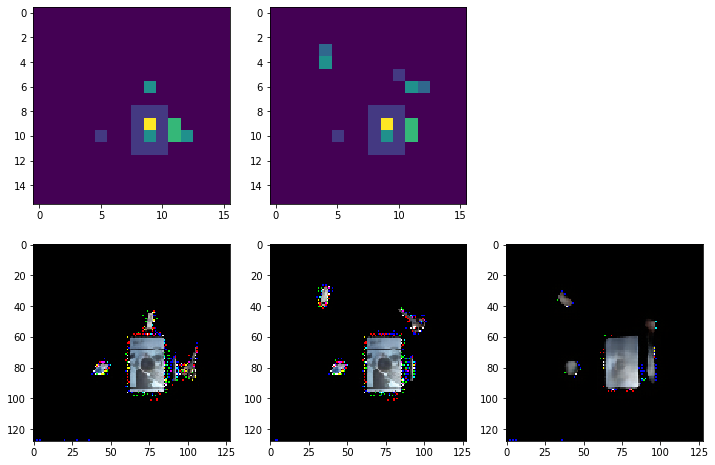

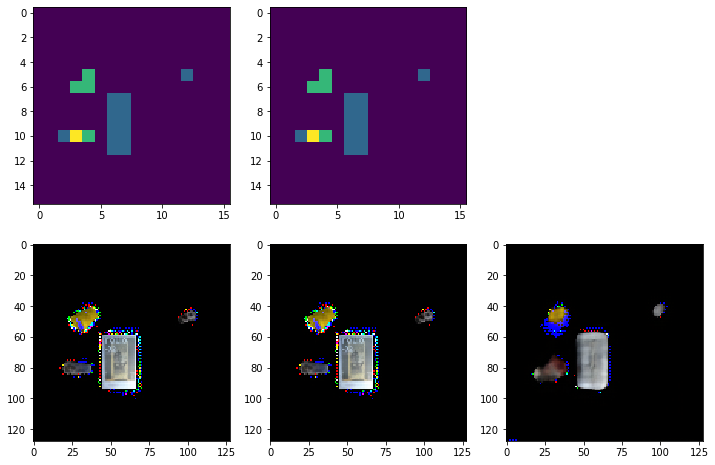

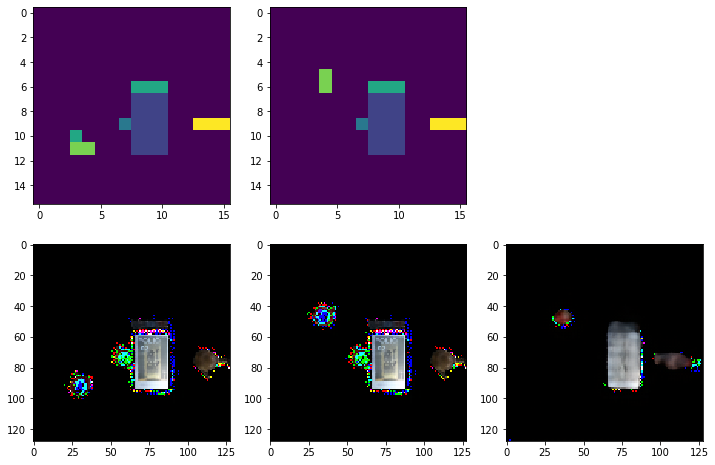

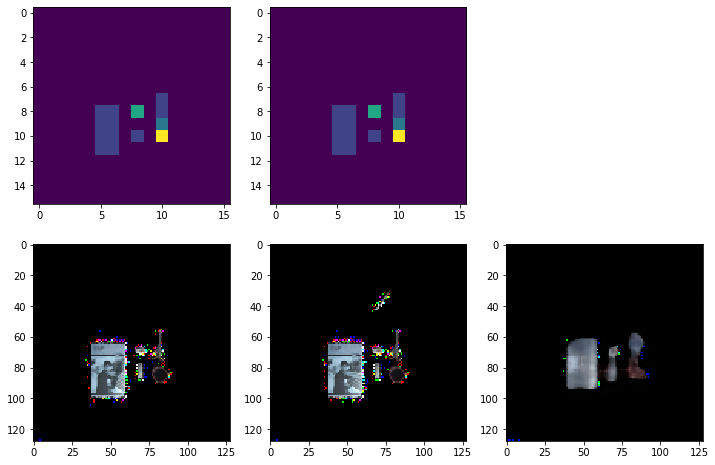

In [23]:
transform = transforms.Compose([Resize([96, 128]), Pad([0, 16, 0, 16])])
transform_seg = transforms.Compose([Resize([96, 128]), Pad([0, 16, 0, 16]), Resize([16, 16])])

for batch in data_loader:
    x_s, masks_s, x_t, masks_t = batch
    x_s = transform(x_s.permute((0, 3, 1, 2))).to(torch.float32).to(device)
    x_t = transform(x_t.permute((0, 3, 1, 2))).to(torch.float32).to(device)
    masks_s = torch.round(transform_seg(masks_s)).to(device)
    masks_t = torch.round(transform_seg(masks_t)).to(device)
    
    posterior_s, _ = encoder(x_s)
    feature_s = posterior_s.mean
    posterior_t, _ = encoder(x_t)
    feature_t = posterior_t.mean

    cond = torch.zeros_like(feature_s)
    for m in range(1, int(masks_s.max())+1):
        mask_source_m = (masks_s==m).to(torch.float32).view(-1, 1, 16, 16)
        count_source_m = mask_source_m.sum((2, 3))
        feature_source_m = mask_source_m * feature_s
        feature_source_m_mean = feature_source_m.sum((2, 3)) / count_source_m
        feature_source_m_mean = torch.where(count_source_m==0, torch.zeros_like(feature_source_m_mean), feature_source_m_mean)
        
        mask_target_m = (masks_t==m).to(torch.float32).view(-1, 1, 16, 16)
        cond += mask_target_m * feature_source_m_mean.view(-1, 16, 1, 1)
    
    feature_recon = diffusion(cond)
    
    img_s = decoder(feature_s)
    img_t = decoder(feature_t)
    img_recon = decoder(feature_recon)
    
    img_s = img_s.permute((0, 2, 3, 1)).detach().cpu()
    img_s = (img_s * 255).numpy().astype(np.uint8)
    
    img_t = img_t.permute((0, 2, 3, 1)).detach().cpu()
    img_t = (img_t * 255).numpy().astype(np.uint8)
    
    img_recon = img_recon.permute((0, 2, 3, 1)).detach().cpu()
    img_recon = (img_recon * 255).numpy().astype(np.uint8)
    
    masks_s_npy = masks_s.detach().cpu().numpy()
    masks_t_npy = masks_t.detach().cpu().numpy()
    for i in range(4):
        f = plt.figure(figsize=(12, 8))
        plt.subplot(2, 3, 1)
        plt.imshow(masks_s_npy[i])
        plt.subplot(2, 3, 2)
        plt.imshow(masks_t_npy[i])
        plt.subplot(2, 3, 4)
        plt.imshow(img_s[i])
        plt.subplot(2, 3, 5)
        plt.imshow(img_t[i])
        plt.subplot(2, 3, 6)
        plt.imshow(img_recon[i])
        plt.show()
    break

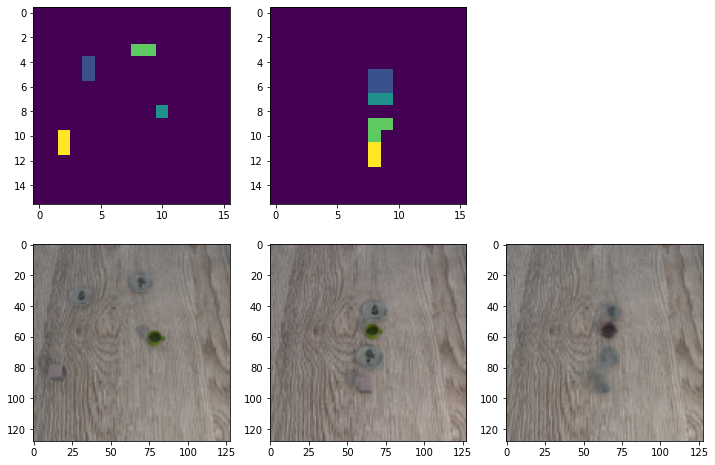

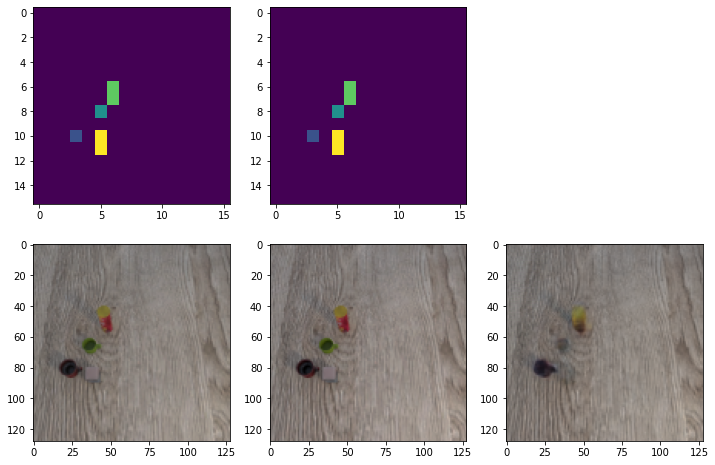

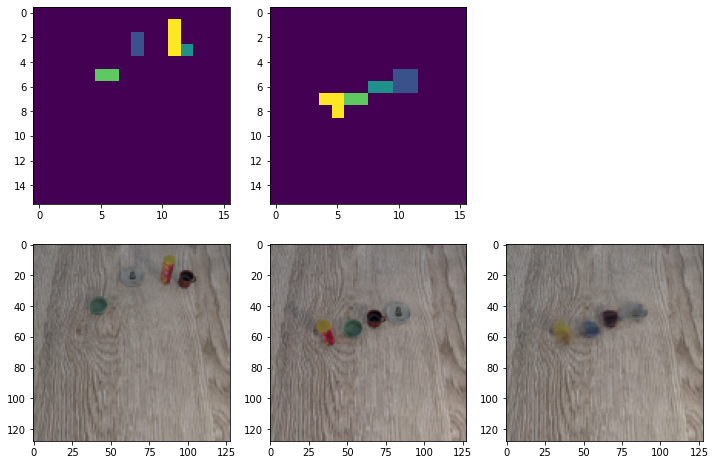

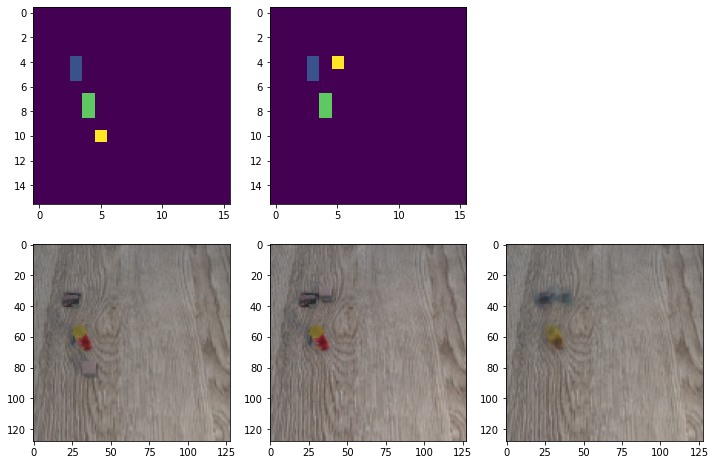

In [7]:
x_s_raw = ((x_s.detach().cpu().permute((0, 2, 3, 1)).numpy() + 1) * 255 / 2).astype(np.uint8)
x_t_raw = ((x_t.detach().cpu().permute((0, 2, 3, 1)).numpy() + 1) * 255 / 2).astype(np.uint8)
masks_s_npy = masks_s.detach().cpu().numpy()
masks_t_npy = masks_t.detach().cpu().numpy()
for i in range(4):
    f = plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(masks_s_npy[i])
    plt.subplot(2, 3, 2)
    plt.imshow(masks_t_npy[i])
    plt.subplot(2, 3, 4)
    plt.imshow(x_s_raw[i])
    plt.subplot(2, 3, 5)
    plt.imshow(x_t_raw[i])
    plt.subplot(2, 3, 6)
    plt.imshow(img_recon[i])
    plt.show()

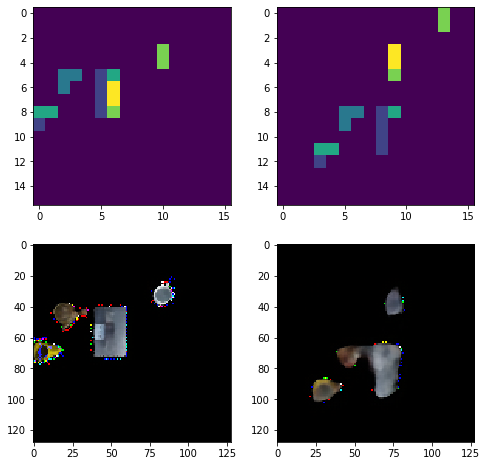

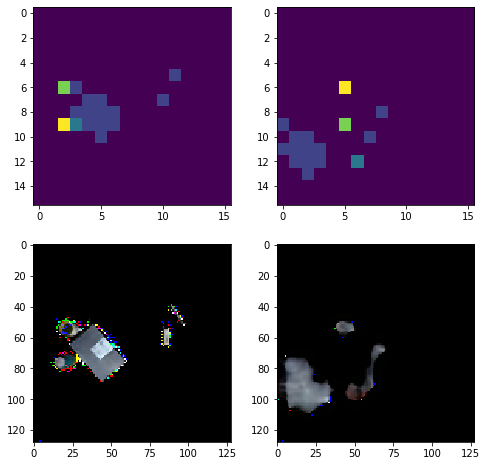

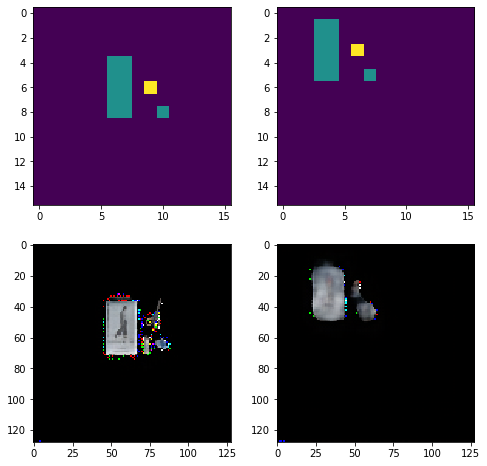

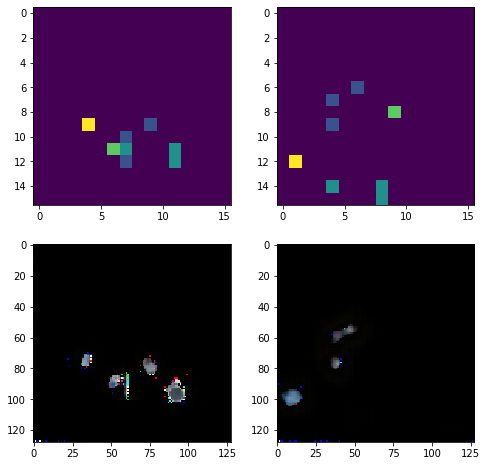

In [29]:
def generate_new_masks(masks):
    new_masks = torch.zeros_like(masks)
    masks_npy = masks.detach().cpu().numpy()
    for m, mask_npy in enumerate(masks_npy):
        new_mask_npy = np.zeros_like(mask_npy)
        for i in range(1, int(mask_npy.max())+1):
            py, px = np.where(mask_npy==i)
            if len(py)==0:
                continue
            while True:
                bias_y, bias_x = np.random.choice([3, -3], 2)
                my, mx = py + bias_y, px + bias_x
                if not (my.max()>=16 or my.min()<0 or mx.max()>=16 or mx.min()<0):
                    break
            new_masks[m, my, mx] = i
    return new_masks

transform = transforms.Compose([Resize([96, 128]), Pad([0, 16, 0, 16])])
transform_seg = transforms.Compose([Resize([96, 128]), Pad([0, 16, 0, 16]), Resize([16, 16])])

for batch in data_loader:
    x_s, masks_s, x_t, masks_t = batch
    x_s = transform(x_s.permute((0, 3, 1, 2))).to(torch.float32).to(device)
    #x_t = transform(x_t.permute((0, 3, 1, 2))).to(torch.float32).to(device)
    #masks_t = masks_t.to(device)
    masks_s = torch.round(transform_seg(masks_s))
    new_masks = generate_new_masks(masks_s)
    masks_s = masks_s.to(device)
    new_masks = new_masks.to(device)
    masks_t = new_masks
    
    posterior_s, _ = encoder(x_s)
    feature_s = posterior_s.mean

    cond = torch.zeros_like(feature_s)
    for m in range(1, int(masks_s.max())+1):
        mask_source_m = (masks_s==m).to(torch.float32).view(-1, 1, 16, 16)
        count_source_m = mask_source_m.sum((2, 3))
        feature_source_m = mask_source_m * feature_s
        feature_source_m_mean = feature_source_m.sum((2, 3)) / count_source_m
        feature_source_m_mean = torch.where(count_source_m==0, torch.zeros_like(feature_source_m_mean), feature_source_m_mean)
        
        mask_target_m = (masks_t==m).to(torch.float32).view(-1, 1, 16, 16)
        cond += mask_target_m * feature_source_m_mean.view(-1, 16, 1, 1)
    
    feature_recon = diffusion(cond)
    
    img_s = decoder(feature_s)
    img_t = decoder(feature_t)
    img_recon = decoder(feature_recon)
    
    img_s = img_s.permute((0, 2, 3, 1)).detach().cpu()
    img_s = (img_s * 255).numpy().astype(np.uint8)
    
    #img_t = img_t.permute((0, 2, 3, 1)).detach().cpu()
    #img_t = ((img_t + 1) * 255 / 2).numpy().astype(np.uint8)
    
    img_recon = img_recon.permute((0, 2, 3, 1)).detach().cpu()
    img_recon = (img_recon * 255).numpy().astype(np.uint8)
    
    masks_s_npy = masks_s.detach().cpu().numpy()
    masks_t_npy = masks_t.detach().cpu().numpy()
    for i in range(4):
        f = plt.figure(figsize=(8, 8))
        #plt.subplot(2, 3, 1)
        #plt.imshow(x_raw[i])
        plt.subplot(2, 2, 1)
        plt.imshow(masks_s_npy[i])
        plt.subplot(2, 2, 2)
        plt.imshow(masks_t_npy[i])
        plt.subplot(2, 2, 3)
        plt.imshow(img_s[i])
        plt.subplot(2, 2, 4)
        plt.imshow(img_recon[i])
        plt.show()
    break